In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import time
import warnings
warnings.filterwarnings("ignore")

## Utility Functions

Since we will be using 5m data, so we'll have to tweak our CAGR and volatitility functions accordingly to take into account 5m intraday data, since they were originally made for daily data. We have assumed 252 trading days in a year and 78 5M candles in a single trading session.

In [3]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


## Getting Stock data
We are mainly focusing on stocks which see a lot of day to day action, ie. mostly tech stocks which have high trading volumes daily.

In [4]:
tickers = ["MSFT", "AAPL", "META", "AMZN", "INTC", "CSCO", "VZ", "IBM", "TSLA", "AMD"]
ohlc_intraday = {}  # Dictionary to store OHLC data for each stock

# Define start and end dates for data retrieval
end_date = dt.datetime.today()
start_date = end_date - dt.timedelta(37)  # Fetch data for at least 36 days

# Loop over tickers and retrieve intraday OHLC data
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker, start=start_date, end=end_date, interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True, how="all")

# Adjust datetime index to UTC timezone for consistency
for ticker in tickers:
    ohlc_intraday[ticker].index = ohlc_intraday[ticker].index.tz_convert('UTC')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Backtesting
The algorithm will be monitoring all the stocks candle by candle and if our criterias are met at a particular candle, the algorithm will place a buy/sell order along with a stop loss. 

#### Strategy Rules :
1. Candle breaching the 20 period rolling max/min price.
2. Volume breaching 1.5 times the rolling max volume of the previous candle.
3. Generate a signal to go buy or sell and append to signal dictionary for the ticker.
4. The trailing stop loss will be set to close price of the candle plus minus 20 period ATR. 

In [5]:
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]

In [6]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    for i in range(1,len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            # If stop loss is hit, change signal form buy to no signal and calculate return and append to tickers_ret dictionary under the correct key.
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
            # If stop loss is hit and criteria are met for the opposite side, open a reversal position and append return to tickers_net under the correct key.
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
            # If the position is open, calculate the return and append to tickers_ret dictionary under the correct key.
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            # If stop loss is hit, change signal form sell to no signal and calculate return and append to tickers_ret dictionary under the correct key.
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            # If stop loss is hit and criteria are met for the opposite side, open a reversal position and append return to tickers_net under the correct key.
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
            # If the position is open, calculate the return and append to tickers_ret dictionary under the correct key.
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

## Calculating Overall Strategy's KPIs

In [7]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [8]:
print("CAGR for the startegy was ",CAGR(strategy_df))
print("Sharpe Ratio for strategy was ",sharpe(strategy_df,0.025))
print("Max Drawdown for strategy was ",max_dd(strategy_df)) 

CAGR for the startegy was  0.12218018905552519
Sharpe Ratio for strategy was  2.536480673479375
Max Drawdown for strategy was  0.006275226606944973


We got a pretty good return of 13% in just a month with minimal drawdown of 0.5%. Seems like a pretty good month for the strategy.

## Visualisation and Results

<function matplotlib.pyplot.show(close=None, block=None)>

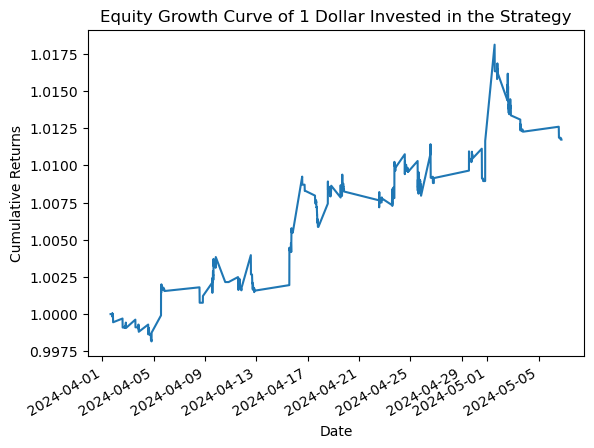

In [9]:
(1+strategy_df["ret"]).cumprod().plot()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title('Equity Growth Curve of 1 Dollar Invested in the Strategy')
plt.show

We can see that we're getting a lot of volatility in this strategy and the cumulative returns actually started going down toward the end of the backtesting period. 

## Calculating individual stock's KPIs

In [10]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

,Return,Sharpe Ratio,Max Drawdown
MSFT,0.317499,2.761759,0.015190
AAPL,-0.111805,-2.835350,0.018823
META,-0.303849,-3.186709,0.047438
AMZN,-0.003087,-0.385450,0.025050
INTC,-0.195007,-2.024773,0.050395
CSCO,-0.092151,-3.585392,0.010220
VZ,1.233887,13.125941,0.008053
IBM,0.411500,3.197799,0.011285
TSLA,0.369092,1.929346,0.046423
AMD,0.267317,1.064028,0.038387


We can see that the tickers that gave positive returns generated massive profits, AMZN was more or less breakeven while returns of META was unusually negative. THe reson for this will be explained in the next section.

## Drawbacks

1. We have assumed in this strategy that we will be getting our trades at the exact close price which is quite difficult in real time markets. This strategy can be improved by incorporating slippage into it.
2. We have not taken into account the cost of fees in calculating the return as the fees can pile up with the number of trades.
3. We have not taken into account closing the trades at End of Day. If the trade is carried forward to the next day, and the stock opens with a gap, then our stop loss will be massively affected. On April 25 META stock opened down 10.5% from it's previous daily close because the investors were disappointed with a sales forecast that missed expectations and news that spending is on the rise. Such events can tank our portfolio and make the strategy lose more koney than it initially intended to.
